# Visualization

## Dependencies

In [1]:
from pathlib import Path
import os
wd=Path().absolute().parent
os.chdir(wd) #change the working dirctory to parant

from modules.func import *
import matplotlib.pyplot as plt
import numpy as np
# from modules.encoder import l
import pickle
from pathlib import Path
from tqdm import tqdm

all_data_dir=Path('./data/alldata/')
datalist=[x for x in all_data_dir.iterdir()]

## Basic Info

In [3]:
# ---load a normal mouse's data
data_dir=datalist[2] # load data
sample_name=str(data_dir).split('/')[-1]
print(f'mouse name:{sample_name}')

position,spikes=data_loader(data_dir)

# basic info

neuron_idx=50
time_bin_size=1/3 #second
num_time_bins,num_cells = spikes.shape

print(f"number of neurons in this mouse:{num_cells} \n")
print(f"loaded data: neuron {neuron_idx}")
print(f"time bin size:{round(time_bin_size,2)}s")
print(f"total time bins:{num_time_bins} ({round(num_time_bins*time_bin_size/60,2)}min)")
print(f"number of spikes:{sum(spikes[:,neuron_idx])}")

mouse name:M45_042718_OF
number of neurons in this mouse:66 

loaded data: neuron 50
time bin size:0.33s
total time bins:5394 (29.97min)
number of spikes:18


## Linear Gaussian Prediction Results
run `decoder.py` before the following code

### Results visulization of two sampels, one camkII, one control

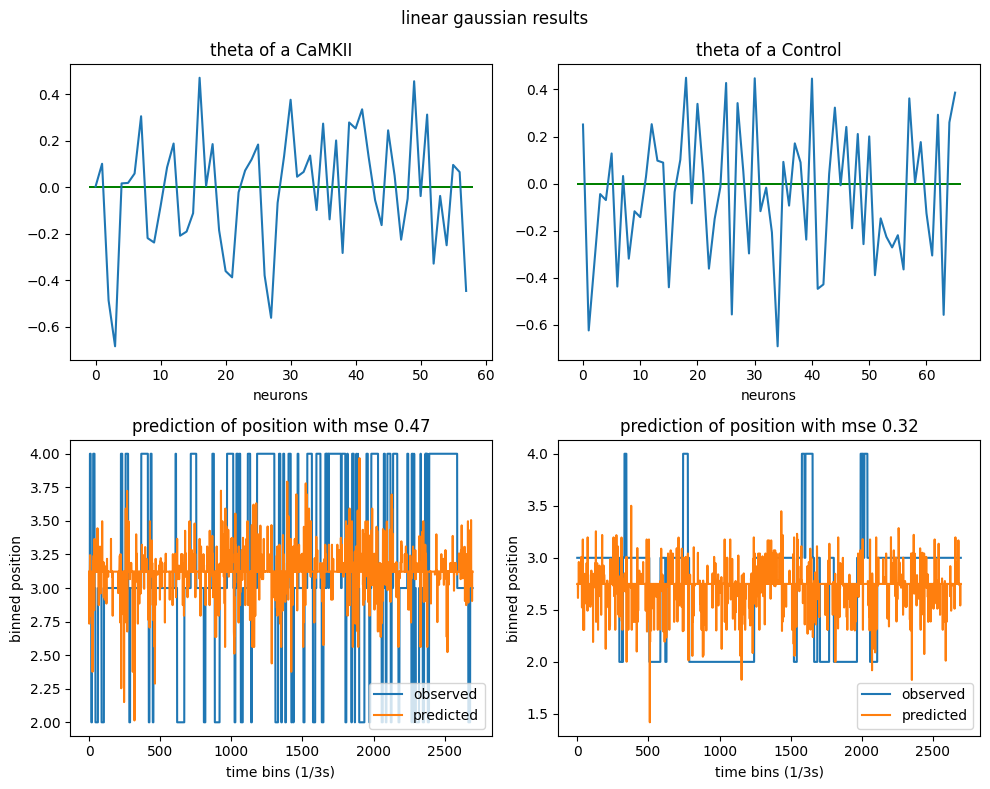

In [5]:
plt.figure(figsize=(10,8))
# -----load prediction results of a camkII
data_dir=datalist[1] # load data
sample_name=str(data_dir).split('/')[-1]
sample_type = "CaMKII" if "CaMKII" in sample_name else "Control"
with open(Path(f"../Output/data/linear_gaussian/lg_predict_{sample_type}.pickle"),"rb") as f:
    theta,prediction,binned_position_test=pickle.load(f)

mse=cal_mse(prediction,binned_position_test)

# plot
plt.subplot(221)
plt.hlines([0]*len(theta[1:]),-1,len(theta)-1,colors="g",lw=.1)
plt.plot(theta[1:]) # exclude the offset
plt.title(f"theta of a {sample_type}")
plt.xlabel("neurons")

plt.subplot(223)
plt.plot(binned_position_test,label="observed")
plt.plot(prediction,label="predicted")
plt.title(f"prediction of position with mse {mse:.2f}")
plt.legend(loc="lower right")
plt.xlabel("time bins (1/3s)")
plt.ylabel("binned position")


# -----load prediction results of a camkII
data_dir=datalist[2] # load data
sample_name=str(data_dir).split('/')[-1]
sample_type = "CaMKII" if "CaMKII" in sample_name else "Control"
with open(Path(f"../Output/data/linear_gaussian/lg_predict_{sample_type}.pickle"),"rb") as f:
    theta,prediction,binned_position_test=pickle.load(f)
mse=cal_mse(prediction,binned_position_test)

# plot
plt.subplot(222)
plt.hlines([0]*len(theta[1:]),-1,len(theta)-1,colors="g",lw=.1)
plt.plot(theta[1:]) # exclude the offset
plt.title(f"theta of a {sample_type}")
plt.xlabel("neurons")

plt.subplot(224)
plt.plot(binned_position_test,label="observed")
plt.plot(prediction,label="predicted")
plt.title(f"prediction of position with mse {mse:.2f}")
plt.legend(loc="lower right")
plt.xlabel("time bins (1/3s)")
plt.ylabel("binned position")

plt.suptitle(f"linear gaussian results")
plt.tight_layout()

# Linear Gaussian Ridge Results

## Penalty Range 0~10

### Two samples' visualization

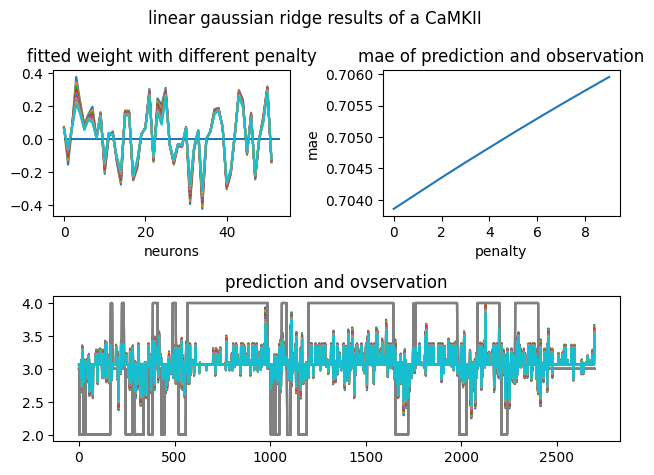

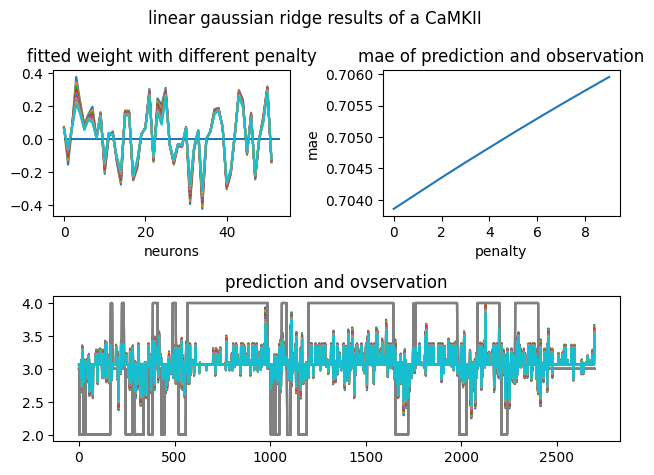

In [33]:
for mouse_id in [0,2]:
    plt.figure()
    data_name=str(datalist[0]).split('/')[-1]
    sample_type = "CaMKII" if "CaMKII" in data_name else "Control"

    with open(Path(f"output/data/linear_gaussian_ridge/lgr_predict_{data_name}.pickle"),"rb") as f:
        theta_prediction_penalty,binned_position_test=pickle.load(f) # load theta(fitted weight), prediction, penealty, and observed position test data
        
    # fig,axes=plt.subplots(ncols=3,figsize=(12,4))
    mae_list=[]
    penalty_list=[]


    for theta,prediction,penalty in theta_prediction_penalty:
        #---plot for theta and penalty
        plt.subplot(221)
        plt.hlines([0]*len(theta),0,len(theta),lw=.1)
        plt.plot(theta[1:],label=penalty)
        plt.title("fitted weight with different penalty")
        plt.xlabel("neurons")
        
        mae_list.append(cal_mae(prediction,binned_position_test))
        penalty_list.append(penalty )

        #---visualize the prediction
        plt.subplot(212)
        plt.plot(binned_position_test,c="gray")
        plt.plot(prediction)
        plt.title("prediction and ovservation")


    #---plot for penalty and mae
    plt.subplot(222)
    plt.plot(penalty_list,mae_list)
    plt.title("mae of prediction and observation")
    plt.xlabel("penalty")
    plt.ylabel("mae")

    plt.suptitle(f"linear gaussian ridge results of a {sample_type}")
    plt.tight_layout()



### Overall resutls

100%|██████████| 12/12 [00:00<00:00, 17.32it/s]


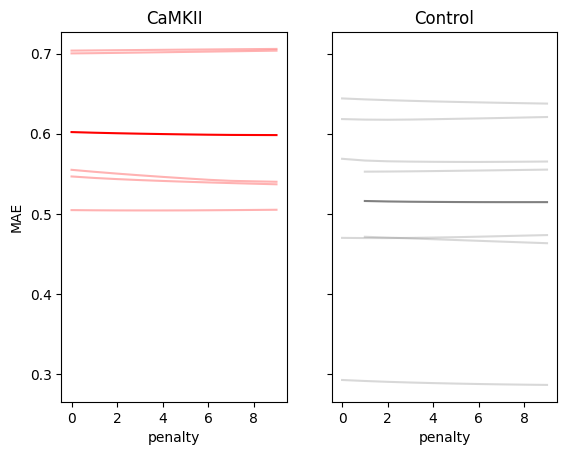

In [20]:
fig,axes=plt.subplots(ncols=2,sharey=True)

mae_list_camkII=[]
mae_list_control=[]
for data_dir in tqdm(datalist):
    data_name=str(data_dir).split('/')[-1]
    with open(Path(f"output/data/linear_gaussian_ridge/lgr_predict_{data_name}.pickle"),"rb") as f:
        theta_prediction_penalty,binned_position_test=pickle.load(f)

    mae_list=[]
    penalty_list=[]
    for theta,prediction,penalty in theta_prediction_penalty:
        mae_list.append(cal_mae(prediction,binned_position_test))
        penalty_list.append(penalty )

    if "CaMKII" in data_name:
        sample_type = "CaMKII"
        mae_list_camkII.append(mae_list)
        axes[0].plot(penalty_list,mae_list,c="r",alpha=.3)
        axes[0].set_title(sample_type)
        axes[0].set_xlabel("penalty")
    else:
        sample_type = "Control"
        mae_list_control.append(mae_list)
        axes[1].plot(penalty_list,mae_list,c="gray",alpha=.3)
        axes[1].set_title(sample_type)
        axes[1].set_xlabel("penalty")

axes[0].set_ylabel("MAE")

#---plot for average mae with different penalty
avg_mae_camkII=np.average(mae_list_camkII,axis=0)
avg_mae_control=np.average(mae_list_control,axis=0)
axes[0].plot(penalty_list,avg_mae_camkII,c="r")
axes[1].plot(penalty_list,avg_mae_control,c="gray")


In [16]:
np.average([[1,2],[3,4]],axis=0)

array([2., 3.])

## Penalty Range 2e3~2e12

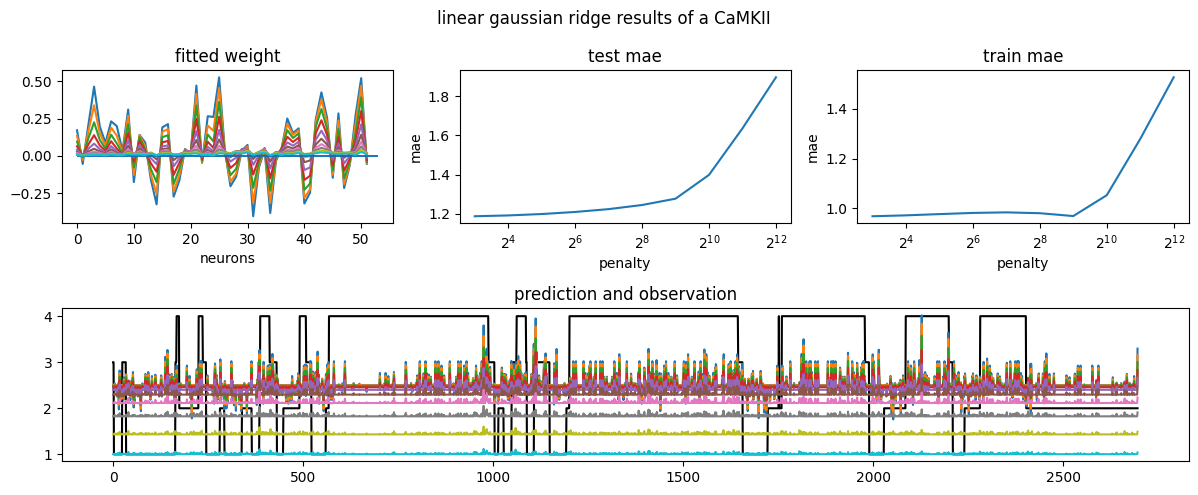

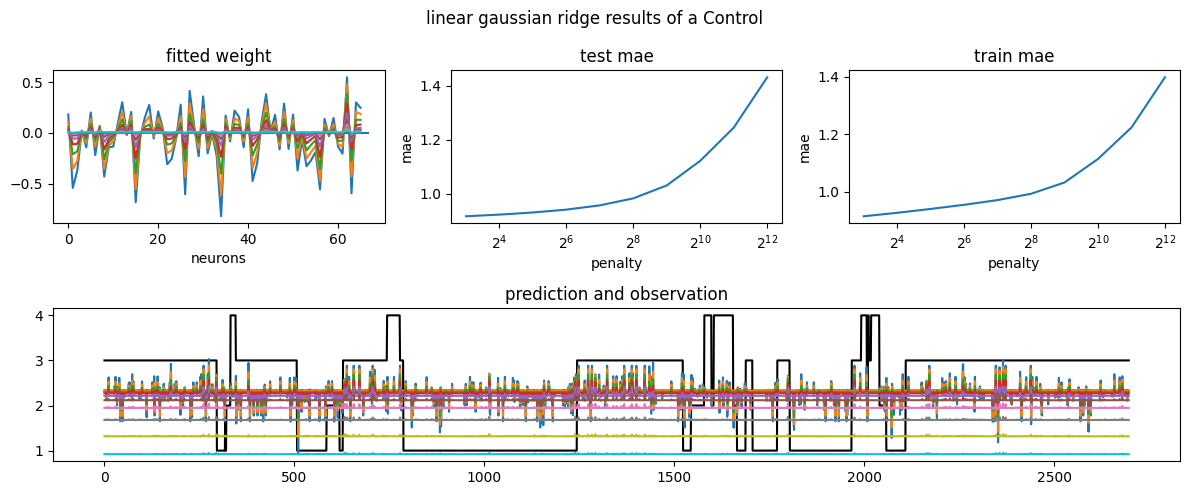

In [8]:
### Two samples' visualization
for mouse_id in [0,2]:
    plt.figure(figsize=(12,5))
    data_name=str(datalist[mouse_id]).split('/')[-1]
    sample_type = "CaMKII" if "CaMKII" in data_name else "Control"

    with open(Path(f"output/data/linear_gaussian_ridge/lgr_predict_{data_name}_withLargerPenalty.pickle"),"rb") as f:
        theta_prediction_penalty,binned_position_test,binned_position_train,failed_penalty=pickle.load(f) # load theta(fitted weight), prediction, penealty, and observed position test data
        
    # fig,axes=plt.subplots(ncols=3,figsize=(12,4))
    mae_list=[]
    mae_train_list=[]
    penalty_list=[]

    # ---visualize the observation
    plt.subplot(212)
    plt.plot(binned_position_test,c="black")

    for theta,prediction,prediction_train,penalty in theta_prediction_penalty:
        #---plot for theta and penalty
        plt.subplot(231)
        plt.hlines([0]*len(theta),0,len(theta),lw=.1)
        plt.plot(theta[1:],label=penalty)
        plt.title("fitted weight")
        plt.xlabel("neurons")
        
        mae_list.append(cal_mae(prediction,binned_position_test))
        mae_train_list.append(cal_mae(prediction_train,binned_position_train))
        penalty_list.append(penalty )

        #---visualize the prediction
        plt.subplot(212)
        plt.plot(prediction)
        plt.title("prediction and observation")


    #---plot for prediction error
    plt.subplot(232)
    plt.semilogx(penalty_list,mae_list,base=2)
    plt.title("test mae")
    plt.xlabel("penalty")
    plt.ylabel("mae")

    plt.subplot(233)
    plt.semilogx(penalty_list,mae_train_list,base=2)
    plt.title("train mae")
    plt.xlabel("penalty")
    plt.ylabel("mae")

    plt.suptitle(f"linear gaussian ridge results of a {sample_type}")
    plt.tight_layout()



100%|██████████| 12/12 [00:00<00:00, 18.19it/s]


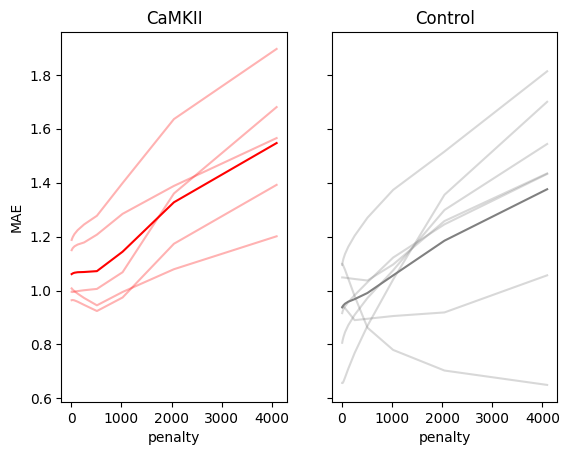

In [5]:
fig,axes=plt.subplots(ncols=2,sharey=True)

mae_list_camkII=[]
mae_list_control=[]
for data_dir in tqdm(datalist):
    data_name=str(data_dir).split('/')[-1]
    with open(Path(f"output/data/linear_gaussian_ridge/lgr_predict_{data_name}_withLargerPenalty.pickle"),"rb") as f:
        theta_prediction_penalty,binned_position_test,binned_position_train,failed_penalty=pickle.load(f) # load theta(fitted weight), prediction, penealty, and observed position test data
   
    mae_list=[]
    penalty_list=[]
    for theta,prediction,prediction_train,penalty in theta_prediction_penalty:
        mae_list.append(cal_mae(prediction,binned_position_test))
        penalty_list.append(penalty )

    if "CaMKII" in data_name:
        sample_type = "CaMKII"
        mae_list_camkII.append(mae_list)
        axes[0].plot(penalty_list,mae_list,c="r",alpha=.3)
        axes[0].set_title(sample_type)
        axes[0].set_xlabel("penalty")
    else:
        sample_type = "Control"
        mae_list_control.append(mae_list)
        axes[1].plot(penalty_list,mae_list,c="gray",alpha=.3)
        axes[1].set_title(sample_type)
        axes[1].set_xlabel("penalty")

axes[0].set_ylabel("MAE")

#---plot for average mae with different penalty
avg_mae_camkII=np.average(mae_list_camkII,axis=0)
avg_mae_control=np.average(mae_list_control,axis=0)
axes[0].plot(penalty_list,avg_mae_camkII,c="r")
axes[1].plot(penalty_list,avg_mae_control,c="gray")
